# Scientific Conversion Analysis

This notebook analyzes the results from the `convert.py` script, examining model performance across:
- Different models (gpt-4o, qwen-coder, llama-4)
- Conversion types (temperature, timezone, moles, bits_bytes, energy, density, volume, speed)
- Difficulty levels (easy, hard, random)
- Context types (context vs context-free)
- City popularity (for timezone conversions)
- Conversion directions

In [14]:
# If you get import errors, run this in a separate cell first:
# import sys
# import subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy", "--target", sys.path[1]])

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Try importing scipy
try:
    from scipy import stats
except ImportError:
    print("scipy not found. Please install it by running:")
    print("  !pip install scipy")
    print("Or in terminal: pip install scipy")
    print("Then restart the kernel.")
    raise

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [15]:
# Configuration: Update this path to your results file
results_file = "/data/jane/math_gender/conversion_test/new_sci_conversion_results/conversion_results_complete_20260121_140946_fixed.json"
output_dir = "analysis_output"

def load_results(results_file):
    """Load the conversion results JSON file."""
    with open(results_file, 'r') as f:
        return json.load(f)

# Load data
print(f"Loading results from: {results_file}")
results = load_results(results_file)

# Convert to DataFrame
df = pd.DataFrame(results)

# Filter out errors
df_clean = df[~df['is_error']].copy()

print(f"\nTotal results: {len(df):,}")
print(f"Valid results (no errors): {len(df_clean):,}")
print(f"Error rate: {(len(df) - len(df_clean)) / len(df) * 100:.2f}%")
print(f"\nModels: {df_clean['model'].unique().tolist()}")
print(f"Conversion types: {df_clean['conversion_name'].unique().tolist()}")
print(f"Difficulty levels: {df_clean['difficulty'].unique().tolist()}")
print(f"Context types: {df_clean['context_type'].unique().tolist()}")

# Create output directory
Path(output_dir).mkdir(exist_ok=True)

df = df_clean

Loading results from: /data/jane/math_gender/conversion_test/new_sci_conversion_results/conversion_results_complete_20260121_140946_fixed.json

Total results: 12,270
Valid results (no errors): 12,228
Error rate: 0.34%

Models: ['gpt-4o', 'qwen-coder', 'llama-4']
Conversion types: ['bits_bytes', 'density', 'energy', 'timezone', 'moles_to_particles']
Difficulty levels: ['easy', 'hard', 'random']
Context types: ['context_free', 'context']


## 1. Overall Accuracy by Model

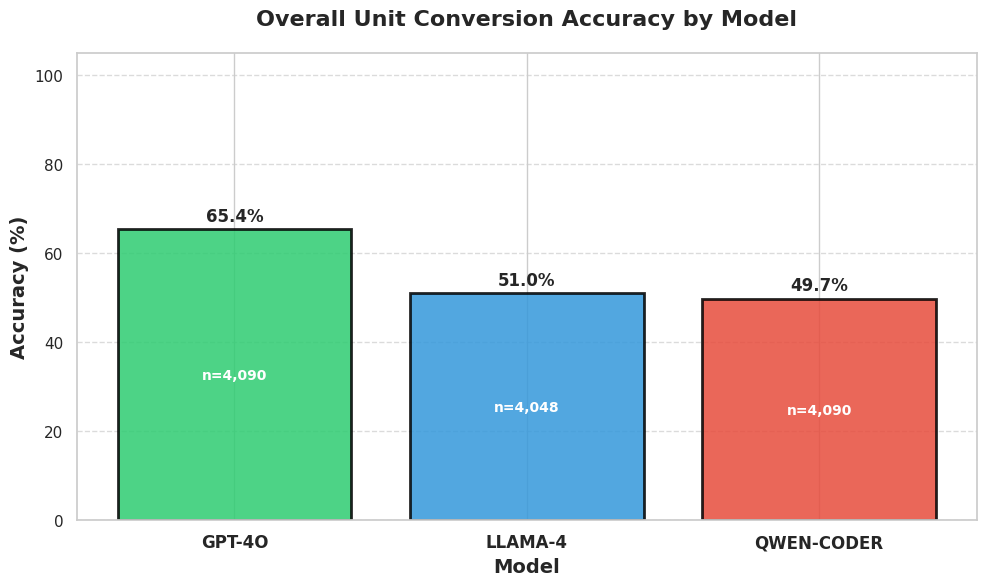


Overall Accuracy Summary:
     model  correct  total  accuracy
    gpt-4o     2674   4090 65.378973
   llama-4     2064   4048 50.988142
qwen-coder     2033   4090 49.706601


In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate accuracy by model
accuracy_data = df.groupby('model')['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
accuracy_data.columns = ['model', 'correct', 'total', 'accuracy']
accuracy_data['accuracy'] = accuracy_data['accuracy'] * 100
accuracy_data = accuracy_data.sort_values('accuracy', ascending=False)

colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax.bar(range(len(accuracy_data)), accuracy_data['accuracy'],
              color=colors[:len(accuracy_data)], edgecolor='black', linewidth=2, alpha=0.85)

ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Overall Unit Conversion Accuracy by Model', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(len(accuracy_data)))
ax.set_xticklabels([m.upper() for m in accuracy_data['model']], fontsize=12, fontweight='bold')
ax.set_ylim(0, 105)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, row) in enumerate(zip(bars, accuracy_data.itertuples())):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
           f'{height:.1f}%', ha='center', va='bottom', 
           fontsize=12, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
           f'n={int(row.total):,}', ha='center', va='center',
           fontsize=10, color='white', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/overall_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nOverall Accuracy Summary:")
print(accuracy_data.to_string(index=False))

## 2. Accuracy by Conversion Type

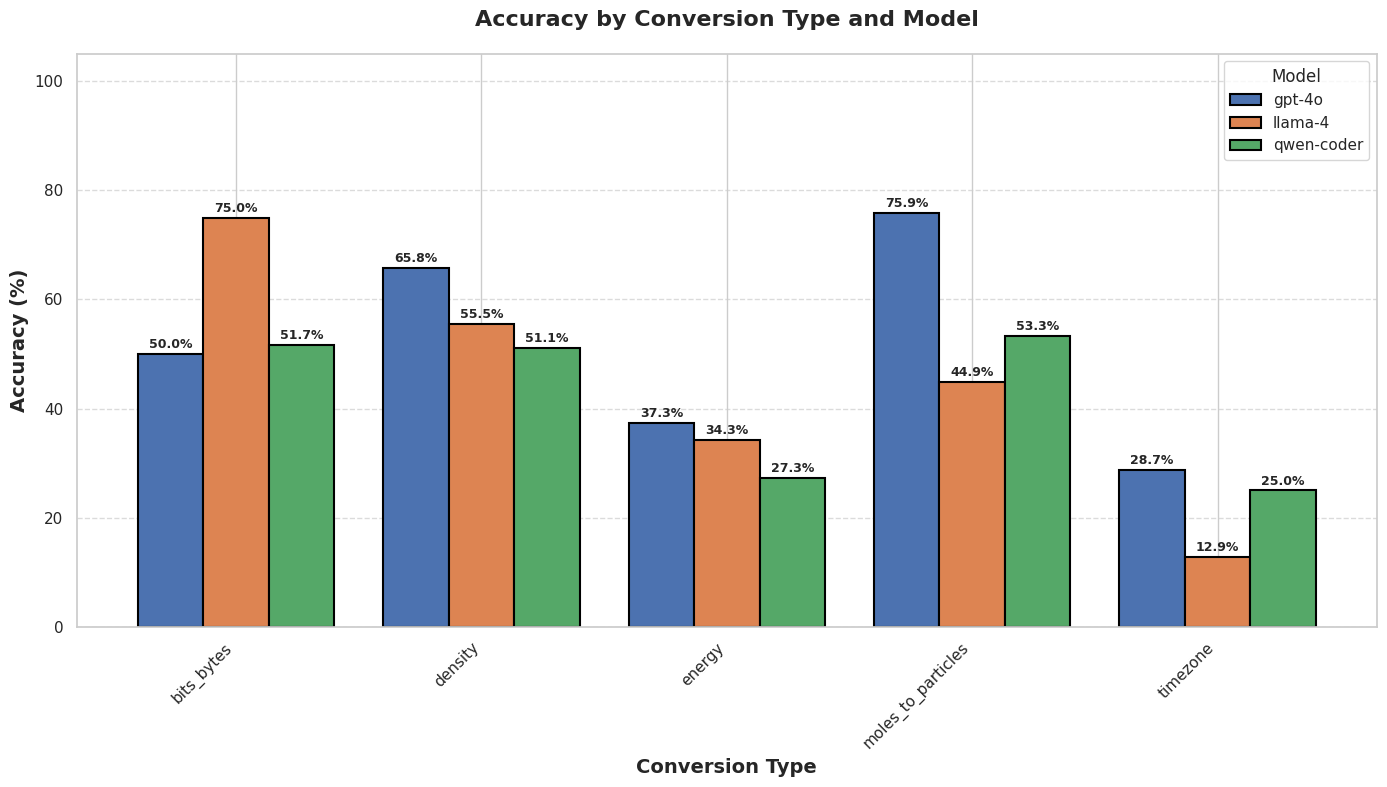


Accuracy by Conversion Type:
model               gpt-4o  llama-4  qwen-coder
conversion_name                                
bits_bytes           50.00    75.00       51.67
density              65.81    55.48       51.08
energy               37.33    34.27       27.33
moles_to_particles   75.91    44.87       53.33
timezone             28.75    12.90       25.00


In [17]:
# Calculate accuracy by conversion type and model
conversion_accuracy = df.groupby(['conversion_name', 'model'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
conversion_accuracy.columns = ['conversion_name', 'model', 'correct', 'total', 'accuracy']
conversion_accuracy['accuracy'] = conversion_accuracy['accuracy'] * 100

# Pivot for easier plotting
conversion_pivot = conversion_accuracy.pivot(index='conversion_name', columns='model', values='accuracy')

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
bars = conversion_pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Conversion Type', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Accuracy by Conversion Type and Model', fontsize=16, fontweight='bold', pad=20)
ax.legend(title='Model', fontsize=11, title_fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, 105)

# Add percentage labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=9, fontweight='bold', padding=2)

plt.tight_layout()
plt.savefig(f'{output_dir}/accuracy_by_conversion_type.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAccuracy by Conversion Type:")
print(conversion_pivot.round(2).to_string())

## 3. Accuracy by Difficulty Level

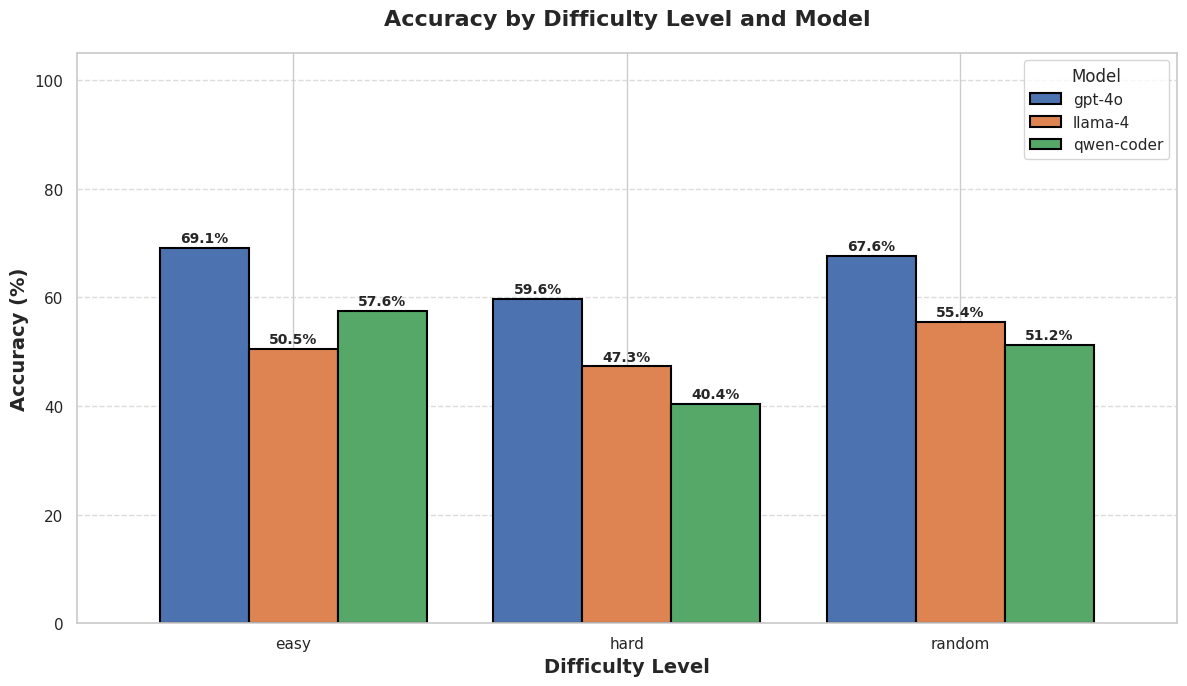


Accuracy by Difficulty Level:
model       gpt-4o  llama-4  qwen-coder
difficulty                             
easy         69.06    50.51       57.55
hard         59.64    47.27       40.43
random       67.56    55.44       51.22


In [18]:
# Calculate accuracy by difficulty and model
difficulty_accuracy = df.groupby(['difficulty', 'model'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
difficulty_accuracy.columns = ['difficulty', 'model', 'correct', 'total', 'accuracy']
difficulty_accuracy['accuracy'] = difficulty_accuracy['accuracy'] * 100

# Pivot for easier plotting
difficulty_pivot = difficulty_accuracy.pivot(index='difficulty', columns='model', values='accuracy')

# Plot
fig, ax = plt.subplots(figsize=(12, 7))
difficulty_pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Difficulty Level', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Accuracy by Difficulty Level and Model', fontsize=16, fontweight='bold', pad=20)
ax.legend(title='Model', fontsize=11, title_fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, 105)

# Add percentage labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=10, fontweight='bold', padding=2)

plt.tight_layout()
plt.savefig(f'{output_dir}/accuracy_by_difficulty.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAccuracy by Difficulty Level:")
print(difficulty_pivot.round(2).to_string())

## 4. Context Effect Analysis

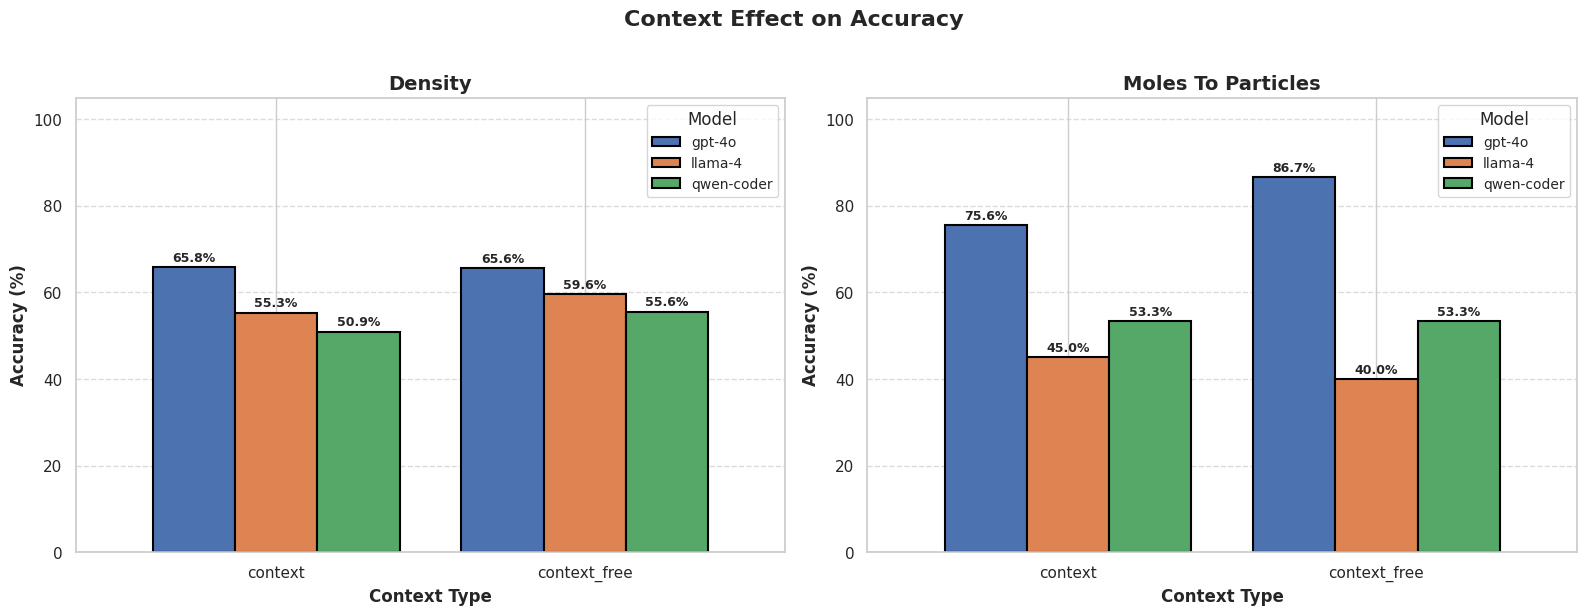


Context Effect Analysis:
model                            gpt-4o  llama-4  qwen-coder
conversion_name    context_type                             
density            context        65.81    55.34       50.93
                   context_free   65.56    59.55       55.56
moles_to_particles context        75.56    45.03       53.33
                   context_free   86.67    40.00       53.33


Statistical Test for Context Effect:
density - gpt-4o: χ²=0.000, p=1.0000
density - qwen-coder: χ²=0.573, p=0.4490
density - llama-4: χ²=0.458, p=0.4983
moles_to_particles - gpt-4o: χ²=1.400, p=0.2368
moles_to_particles - qwen-coder: χ²=0.000, p=1.0000
moles_to_particles - llama-4: χ²=0.129, p=0.7199


In [19]:
context_conversions = ['density', 'moles_to_particles']
df_context = df[df['conversion_name'].isin(context_conversions)].copy()

if len(df_context) > 0:
    # Calculate accuracy by context type
    context_accuracy = df_context.groupby(['conversion_name', 'context_type', 'model'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
    context_accuracy.columns = ['conversion_name', 'context_type', 'model', 'correct', 'total', 'accuracy']
    context_accuracy['accuracy'] = context_accuracy['accuracy'] * 100
    
    # Plot
    fig, axes = plt.subplots(1, len(context_conversions), figsize=(16, 6))
    if len(context_conversions) == 1:
        axes = [axes]
    
    for idx, conv_name in enumerate(context_conversions):
        conv_data = context_accuracy[context_accuracy['conversion_name'] == conv_name]
        if len(conv_data) > 0:
            conv_pivot = conv_data.pivot(index='context_type', columns='model', values='accuracy')
            conv_pivot.plot(kind='bar', ax=axes[idx], width=0.8, edgecolor='black', linewidth=1.5)
            axes[idx].set_title(f'{conv_name.replace("_", " ").title()}', fontsize=14, fontweight='bold')
            axes[idx].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Context Type', fontsize=12, fontweight='bold')
            axes[idx].legend(title='Model', fontsize=10)
            axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)
            axes[idx].yaxis.grid(True, linestyle='--', alpha=0.7)
            axes[idx].set_axisbelow(True)
            axes[idx].set_ylim(0, 105)
            # Add percentage labels on top of bars
            for container in axes[idx].containers:
                axes[idx].bar_label(container, fmt='%.1f%%', fontsize=9, fontweight='bold', padding=2)
    
    plt.suptitle('Context Effect on Accuracy', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/context_effect.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nContext Effect Analysis:")
    print(context_accuracy.pivot_table(index=['conversion_name', 'context_type'], 
                                       columns='model', values='accuracy', aggfunc='mean').round(2).to_string())
    
    # Statistical test for context effect
    print("\n\nStatistical Test for Context Effect:")
    for conv_name in context_conversions:
        conv_df = df_context[df_context['conversion_name'] == conv_name]
        for model in conv_df['model'].unique():
            model_df = conv_df[conv_df['model'] == model]
            context_free = model_df[model_df['context_type'] == 'context_free']['is_correct']
            context = model_df[model_df['context_type'] == 'context']['is_correct']
            
            if len(context_free) > 0 and len(context) > 0:
                chi2, p_value = stats.chi2_contingency(pd.crosstab(
                    model_df['context_type'], model_df['is_correct']
                ))[:2]
                print(f"{conv_name} - {model}: χ²={chi2:.3f}, p={p_value:.4f}")
else:
    print("No context/context-free comparisons available in this dataset.")

## 5. Timezone Analysis: City Popularity Effect

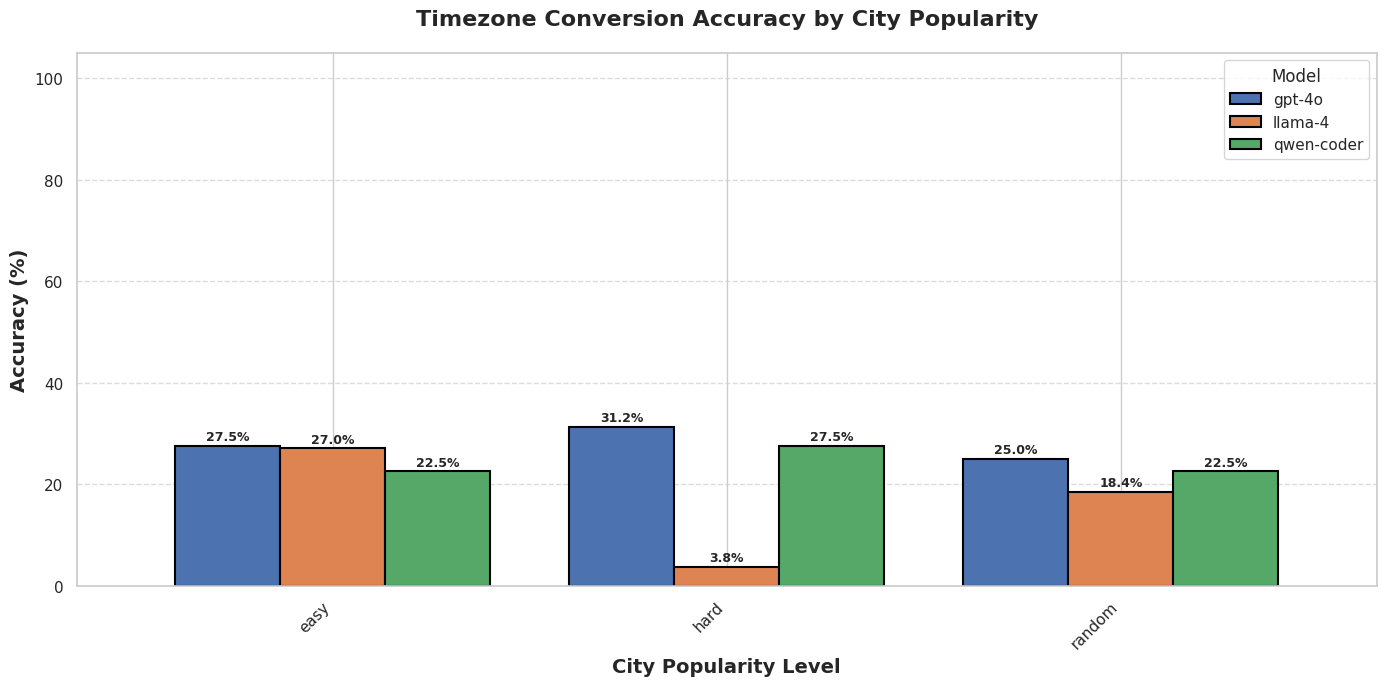


Timezone Accuracy by City Popularity:
model            gpt-4o  llama-4  qwen-coder
city_popularity                             
easy              27.50    27.03        22.5
hard              31.25     3.75        27.5
random            25.00    18.42        22.5


In [20]:
# Filter to timezone conversions
df_timezone = df[df['conversion_name'] == 'timezone'].copy()

if len(df_timezone) > 0 and 'city_popularity' in df_timezone.columns:
    # Calculate accuracy by city popularity
    popularity_accuracy = df_timezone.groupby(['city_popularity', 'model'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
    popularity_accuracy.columns = ['city_popularity', 'model', 'correct', 'total', 'accuracy']
    popularity_accuracy['accuracy'] = popularity_accuracy['accuracy'] * 100
    
    # Order by popularity (if using standard levels)
    popularity_order = ['very_well_known', 'well_known', 'moderately_known', 'less_known', 'obscure', 'easy', 'random', 'hard']
    popularity_accuracy['popularity_order'] = popularity_accuracy['city_popularity'].apply(
        lambda x: popularity_order.index(x) if x in popularity_order else 999
    )
    popularity_accuracy = popularity_accuracy.sort_values('popularity_order')
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 7))
    popularity_pivot = popularity_accuracy.pivot(index='city_popularity', columns='model', values='accuracy')
    popularity_pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('City Popularity Level', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Timezone Conversion Accuracy by City Popularity', fontsize=16, fontweight='bold', pad=20)
    ax.legend(title='Model', fontsize=11, title_fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.set_ylim(0, 105)
    
    # Add percentage labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=9, fontweight='bold', padding=2)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/timezone_popularity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTimezone Accuracy by City Popularity:")
    print(popularity_pivot.round(2).to_string())
else:
    print("No timezone data with city_popularity field available.")

## 6. Conversion Direction Analysis

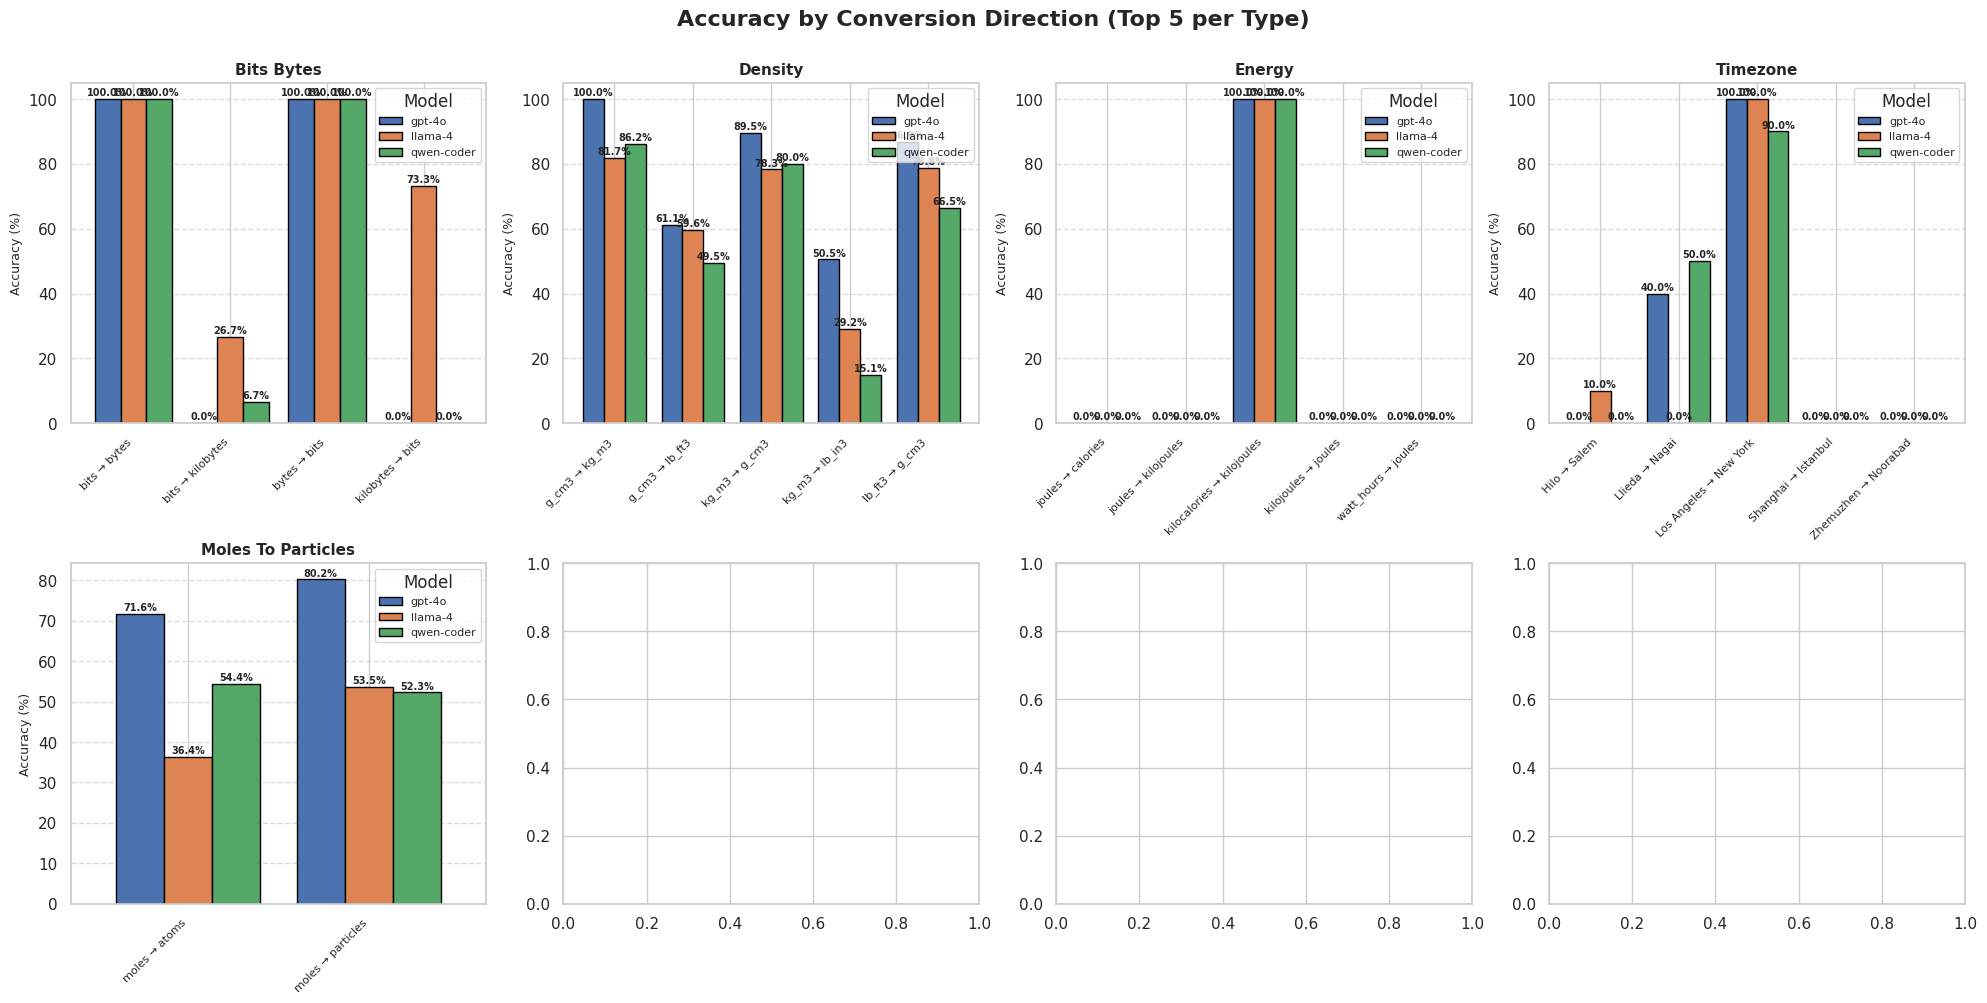

In [ ]:
# Create conversion direction column
df['conversion_direction'] = df['from_unit'] + ' → ' + df['to_unit']

# For each conversion type, analyze top conversion directions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

conversion_types = df['conversion_name'].unique()

for idx, conv_name in enumerate(conversion_types[:8]):  # Limit to 8 for visualization
    conv_df = df[df['conversion_name'] == conv_name]
    
    # Get top 5 conversion directions by count
    top_directions = conv_df['conversion_direction'].value_counts().head(5).index
    conv_df_top = conv_df[conv_df['conversion_direction'].isin(top_directions)]
    
    if len(conv_df_top) > 0:
        direction_accuracy = conv_df_top.groupby(['conversion_direction', 'model'])['is_correct'].mean() * 100
        direction_accuracy = direction_accuracy.reset_index()
        direction_pivot = direction_accuracy.pivot(index='conversion_direction', columns='model', values='is_correct')
        
        direction_pivot.plot(kind='bar', ax=axes[idx], width=0.8, edgecolor='black', linewidth=1)
        axes[idx].set_title(f'{conv_name.replace("_", " ").title()}', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Accuracy (%)', fontsize=9)
        axes[idx].set_xlabel('', fontsize=9)
        axes[idx].legend(title='Model', fontsize=8)
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right', fontsize=8)
        axes[idx].yaxis.grid(True, linestyle='--', alpha=0.7)
        axes[idx].set_axisbelow(True)
        # Add percentage labels on top of bars
        for container in axes[idx].containers:
            axes[idx].bar_label(container, fmt='%.1f%%', fontsize=7, fontweight='bold', padding=1)

plt.suptitle('Accuracy by Conversion Direction (Top 5 per Type)', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig(f'{output_dir}/conversion_direction.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Error Analysis

No errors found in the dataset.


Incorrect Answers Analysis (numeric conversions only):
Total incorrect (non-error) numeric answers: 5088
Timezone incorrect answers (excluded from relative error): 369

Average relative error by model:
model
gpt-4o         14771.94
llama-4       124196.60
qwen-coder      9998.30

Average relative error by conversion type:
conversion_name
bits_bytes              2795.45
density                59795.68
energy                185965.62
moles_to_particles       246.60


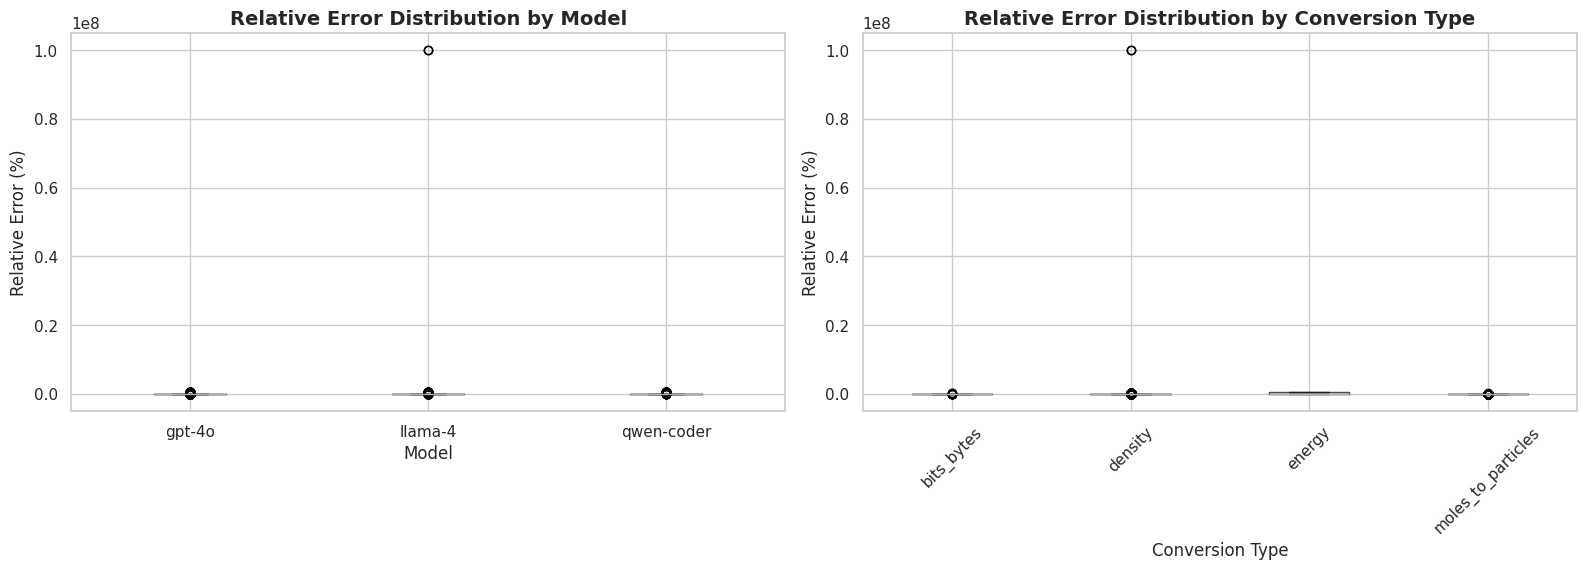

In [ ]:
# Analyze errors
df_errors = df[df['is_error'] == True] if 'is_error' in df.columns else pd.DataFrame()

if len(df_errors) > 0:
    print(f"Total errors: {len(df_errors)}")
    print(f"\nError rate by model:")
    error_by_model = df_errors.groupby('model').size() / df.groupby('model').size() * 100
    print(error_by_model.round(2).to_string())
    
    print(f"\nError rate by conversion type:")
    error_by_conv = df_errors.groupby('conversion_name').size() / df.groupby('conversion_name').size() * 100
    print(error_by_conv.round(2).to_string())
else:
    print("No errors found in the dataset.")

# Analyze incorrect answers (non-errors but wrong)
df_incorrect = df[(df['is_correct'] == False) & (df['is_error'] == False)].copy()

if len(df_incorrect) > 0:
    print(f"\n\nTotal incorrect answers (non-errors): {len(df_incorrect)}")
    
    # Filter out timezone conversions (they use string comparisons, not numeric)
    df_incorrect_numeric = df_incorrect[df_incorrect['conversion_name'] != 'timezone'].copy()
    
    if len(df_incorrect_numeric) > 0:
        # Calculate relative error for incorrect answers (only for numeric conversions)
        # Ensure both model_answer and correct_answer are numeric
        df_incorrect_numeric['model_answer'] = pd.to_numeric(df_incorrect_numeric['model_answer'], errors='coerce')
        df_incorrect_numeric['correct_answer'] = pd.to_numeric(df_incorrect_numeric['correct_answer'], errors='coerce')
        
        # Filter out any rows where conversion failed
        df_incorrect_numeric = df_incorrect_numeric[
            df_incorrect_numeric['model_answer'].notna() & 
            df_incorrect_numeric['correct_answer'].notna()
        ]
        
        if len(df_incorrect_numeric) > 0:
            df_incorrect_numeric['relative_error'] = np.abs(
                (df_incorrect_numeric['model_answer'] - df_incorrect_numeric['correct_answer']) / 
                (df_incorrect_numeric['correct_answer'] + 1e-10)  # Avoid division by zero
            ) * 100
            
            # Cap relative error at 1000% for better visualization (log scale will show full range)
            df_incorrect_numeric['relative_error_capped'] = np.minimum(df_incorrect_numeric['relative_error'], 1000)
            
            print(f"Total incorrect (non-error) numeric answers: {len(df_incorrect_numeric)}")
            print(f"Timezone incorrect answers (excluded from relative error): {len(df_incorrect) - len(df_incorrect_numeric)}")
            print(f"\nAverage relative error by model:")
            error_by_model = df_incorrect_numeric.groupby('model')['relative_error'].agg(['mean', 'median', 'std']).round(2)
            print(error_by_model.to_string())
            
            print(f"\nAverage relative error by conversion type:")
            error_by_conv = df_incorrect_numeric.groupby('conversion_name')['relative_error'].agg(['mean', 'median', 'std']).round(2)
            print(error_by_conv.to_string())
            
            # Create comprehensive error analysis visualizations
            fig = plt.figure(figsize=(18, 12))
            gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
            
            # 1. Average relative error by model (bar chart)
            ax1 = fig.add_subplot(gs[0, 0])
            error_means_model = df_incorrect_numeric.groupby('model')['relative_error'].mean().sort_values(ascending=False)
            bars1 = ax1.bar(range(len(error_means_model)), error_means_model.values, 
                           color=['#e74c3c', '#3498db', '#2ecc71'][:len(error_means_model)],
                           edgecolor='black', linewidth=2, alpha=0.85)
            ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Average Relative Error (%)', fontsize=12, fontweight='bold')
            ax1.set_title('Average Relative Error by Model', fontsize=14, fontweight='bold')
            ax1.set_xticks(range(len(error_means_model)))
            ax1.set_xticklabels([m.upper() for m in error_means_model.index], fontsize=11, fontweight='bold')
            ax1.yaxis.grid(True, linestyle='--', alpha=0.7)
            ax1.set_axisbelow(True)
            # Add value labels
            for i, (bar, val) in enumerate(zip(bars1, error_means_model.values)):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.1f}%', ha='center', va='bottom', 
                        fontsize=11, fontweight='bold')
            
            # 2. Average relative error by conversion type (bar chart)
            ax2 = fig.add_subplot(gs[0, 1])
            error_means_conv = df_incorrect_numeric.groupby('conversion_name')['relative_error'].mean().sort_values(ascending=False)
            bars2 = ax2.bar(range(len(error_means_conv)), error_means_conv.values,
                           color='#9b59b6', edgecolor='black', linewidth=2, alpha=0.85)
            ax2.set_xlabel('Conversion Type', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Average Relative Error (%)', fontsize=12, fontweight='bold')
            ax2.set_title('Average Relative Error by Conversion Type', fontsize=14, fontweight='bold')
            ax2.set_xticks(range(len(error_means_conv)))
            ax2.set_xticklabels([c.replace('_', ' ').title() for c in error_means_conv.index], 
                               rotation=45, ha='right', fontsize=10)
            ax2.yaxis.grid(True, linestyle='--', alpha=0.7)
            ax2.set_axisbelow(True)
            # Add value labels
            for i, (bar, val) in enumerate(zip(bars2, error_means_conv.values)):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.1f}%', ha='center', va='bottom', 
                        fontsize=10, fontweight='bold')
            
            # 3. Relative error distribution by model (histogram with log scale)
            ax3 = fig.add_subplot(gs[1, 0])
            for model in df_incorrect_numeric['model'].unique():
                model_data = df_incorrect_numeric[df_incorrect_numeric['model'] == model]['relative_error']
                # Use log scale for better visualization
                model_data_log = np.log10(model_data + 1)  # +1 to avoid log(0)
                ax3.hist(model_data_log, bins=30, alpha=0.6, label=model.upper(), edgecolor='black', linewidth=0.5)
            ax3.set_xlabel('Log10(Relative Error + 1) (%)', fontsize=12, fontweight='bold')
            ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
            ax3.set_title('Relative Error Distribution by Model (Log Scale)', fontsize=14, fontweight='bold')
            ax3.legend(fontsize=10)
            ax3.yaxis.grid(True, linestyle='--', alpha=0.7)
            ax3.set_axisbelow(True)
            
            # 4. Relative error distribution by conversion type (box plot)
            ax4 = fig.add_subplot(gs[1, 1])
            top_conversions = df_incorrect_numeric['conversion_name'].value_counts().head(8).index
            df_incorrect_top = df_incorrect_numeric[df_incorrect_numeric['conversion_name'].isin(top_conversions)].copy()
            # Use log scale for boxplot
            df_incorrect_top['relative_error_log'] = np.log10(df_incorrect_top['relative_error'] + 1)
            box_data = [df_incorrect_top[df_incorrect_top['conversion_name'] == conv]['relative_error_log'].values 
                       for conv in top_conversions]
            bp = ax4.boxplot(box_data, labels=[c.replace('_', ' ').title() for c in top_conversions],
                            patch_artist=True, showmeans=True)
            for patch in bp['boxes']:
                patch.set_facecolor('#f39c12')
                patch.set_alpha(0.7)
            ax4.set_ylabel('Log10(Relative Error + 1) (%)', fontsize=12, fontweight='bold')
            ax4.set_title('Relative Error Distribution by Conversion Type', fontsize=14, fontweight='bold')
            ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right', fontsize=9)
            ax4.yaxis.grid(True, linestyle='--', alpha=0.7)
            ax4.set_axisbelow(True)
            
            # 5. Error rate by model and conversion type (heatmap)
            ax5 = fig.add_subplot(gs[2, :])
            error_rate_pivot = df_incorrect_numeric.groupby(['conversion_name', 'model']).size().unstack(fill_value=0)
            # Calculate error rate as percentage of total attempts
            total_pivot = df[df['conversion_name'] != 'timezone'].groupby(['conversion_name', 'model']).size().unstack(fill_value=1)
            error_rate_pct = (error_rate_pivot / total_pivot * 100).round(1)
            sns.heatmap(error_rate_pct, annot=True, fmt='.1f', cmap='Reds', 
                       vmin=0, vmax=100, ax=ax5, cbar_kws={'label': 'Error Rate (%)'})
            ax5.set_xlabel('Model', fontsize=12, fontweight='bold')
            ax5.set_ylabel('Conversion Type', fontsize=12, fontweight='bold')
            ax5.set_title('Incorrect Answer Rate by Conversion Type and Model', fontsize=14, fontweight='bold')
            
            plt.suptitle('Error Analysis: Incorrect Answers (Non-Errors)', fontsize=16, fontweight='bold', y=0.995)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/error_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"\n\nError analysis visualization saved to {output_dir}/error_analysis.png")
        else:
            print("\n\nNo valid numeric incorrect answers found for relative error analysis.")
    else:
        print("\n\nAll incorrect answers are from timezone conversions (string-based, not numeric).")
else:
    print("\n\nNo incorrect answers found in the dataset.")

## 8. Comprehensive Summary Table

In [23]:
# Create comprehensive summary
summary_data = []

for model in df['model'].unique():
    model_df = df[df['model'] == model]
    
    for conv_name in df['conversion_name'].unique():
        conv_df = model_df[model_df['conversion_name'] == conv_name]
        
        for difficulty in df['difficulty'].unique():
            diff_df = conv_df[conv_df['difficulty'] == difficulty]
            
            if len(diff_df) > 0:
                accuracy = diff_df['is_correct'].mean() * 100
                total = len(diff_df)
                correct = diff_df['is_correct'].sum()
                
                summary_data.append({
                    'model': model,
                    'conversion_name': conv_name,
                    'difficulty': difficulty,
                    'accuracy': accuracy,
                    'correct': correct,
                    'total': total
                })

summary_df = pd.DataFrame(summary_data)

# Save summary to CSV
summary_df.to_csv(f'{output_dir}/summary_comprehensive.csv', index=False)
print(f"\nComprehensive summary saved to {output_dir}/summary_comprehensive.csv")
print(f"\nSummary preview (first 20 rows):")
print(summary_df.head(20).to_string(index=False))


Comprehensive summary saved to analysis_output/summary_comprehensive.csv

Summary preview (first 20 rows):
     model    conversion_name difficulty  accuracy  correct  total
    gpt-4o         bits_bytes       easy 50.000000       10     20
    gpt-4o         bits_bytes       hard 50.000000       10     20
    gpt-4o         bits_bytes     random 50.000000       10     20
    gpt-4o            density       easy 68.279570      635    930
    gpt-4o            density       hard 62.688172      583    930
    gpt-4o            density     random 66.451613      618    930
    gpt-4o             energy       easy 32.000000       16     50
    gpt-4o             energy       hard 40.000000       20     50
    gpt-4o             energy     random 40.000000       20     50
    gpt-4o           timezone       easy 32.500000       26     80
    gpt-4o           timezone       hard 25.000000       20     80
    gpt-4o moles_to_particles       easy 88.064516      273    310
    gpt-4o moles_to_p

## 9. Statistical Comparisons

In [24]:
# Statistical tests comparing models
print("Statistical Comparisons Between Models:\n")

models = df['model'].unique()
if len(models) >= 2:
    from itertools import combinations
    
    for model1, model2 in combinations(models, 2):
        model1_data = df[df['model'] == model1]['is_correct']
        model2_data = df[df['model'] == model2]['is_correct']
        
        # Chi-square test
        contingency = pd.crosstab(df[df['model'].isin([model1, model2])]['model'], 
                                 df[df['model'].isin([model1, model2])]['is_correct'])
        chi2, p_value = stats.chi2_contingency(contingency)[:2]
        
        print(f"{model1} vs {model2}:")
        print(f"  Chi-square: {chi2:.3f}, p-value: {p_value:.6f}")
        print(f"  {model1} accuracy: {model1_data.mean()*100:.2f}%")
        print(f"  {model2} accuracy: {model2_data.mean()*100:.2f}%")
        print()

Statistical Comparisons Between Models:

gpt-4o vs qwen-coder:
  Chi-square: 204.958, p-value: 0.000000
  gpt-4o accuracy: 65.38%
  qwen-coder accuracy: 49.71%

gpt-4o vs llama-4:
  Chi-square: 172.621, p-value: 0.000000
  gpt-4o accuracy: 65.38%
  llama-4 accuracy: 50.99%

qwen-coder vs llama-4:
  Chi-square: 1.286, p-value: 0.256824
  qwen-coder accuracy: 49.71%
  llama-4 accuracy: 50.99%



## 10. Heatmap: Accuracy by Conversion Type and Difficulty

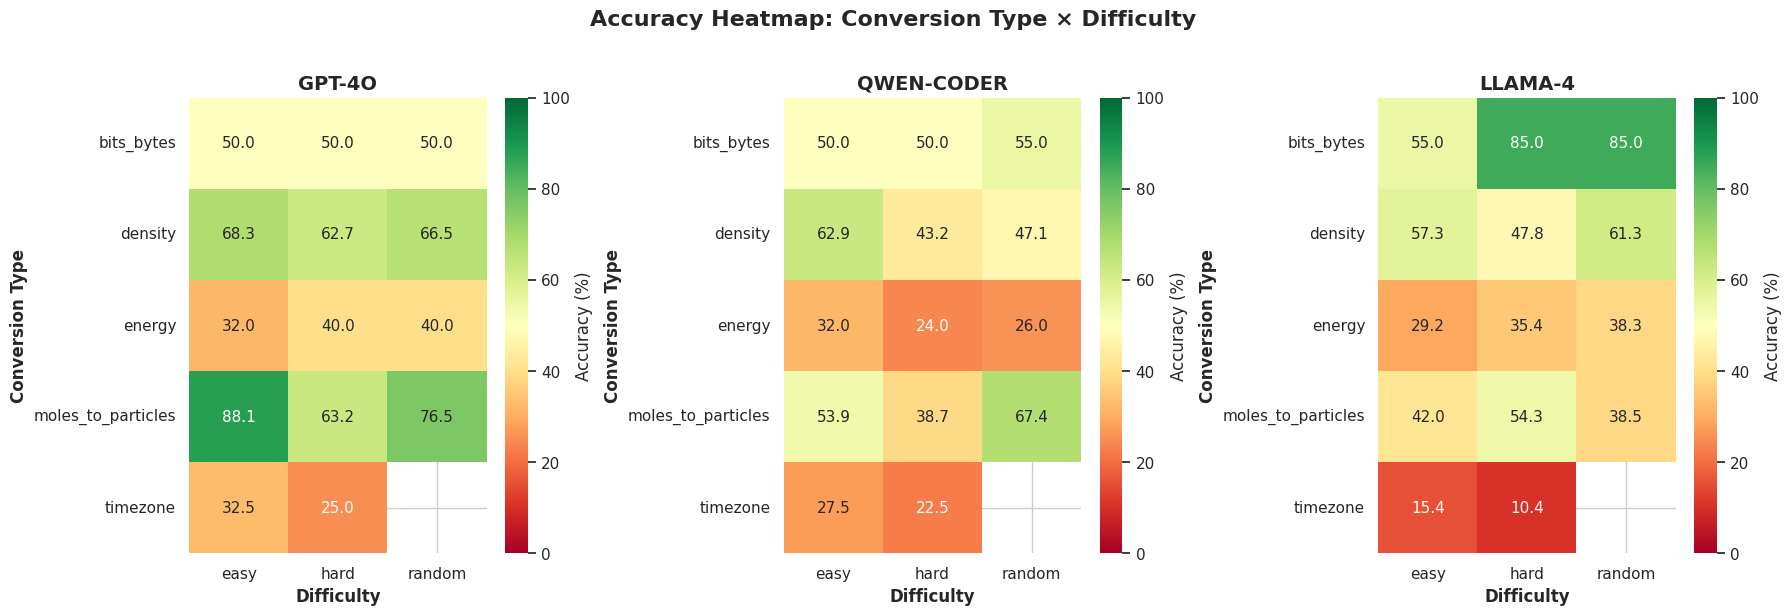

In [25]:
# Create heatmap for each model
fig, axes = plt.subplots(1, len(df['model'].unique()), figsize=(18, 6))
if len(df['model'].unique()) == 1:
    axes = [axes]

for idx, model in enumerate(df['model'].unique()):
    model_df = df[df['model'] == model]
    
    # Create pivot table
    heatmap_data = model_df.groupby(['conversion_name', 'difficulty'])['is_correct'].mean() * 100
    heatmap_pivot = heatmap_data.reset_index().pivot(index='conversion_name', 
                                                      columns='difficulty', 
                                                      values='is_correct')
    
    # Plot heatmap
    sns.heatmap(heatmap_pivot, annot=True, fmt='.1f', cmap='RdYlGn', 
                vmin=0, vmax=100, ax=axes[idx], cbar_kws={'label': 'Accuracy (%)'})
    axes[idx].set_title(f'{model.upper()}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Difficulty', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Conversion Type', fontsize=12, fontweight='bold')

plt.suptitle('Accuracy Heatmap: Conversion Type × Difficulty', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}/accuracy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Context-Specific Analysis (for density and moles)

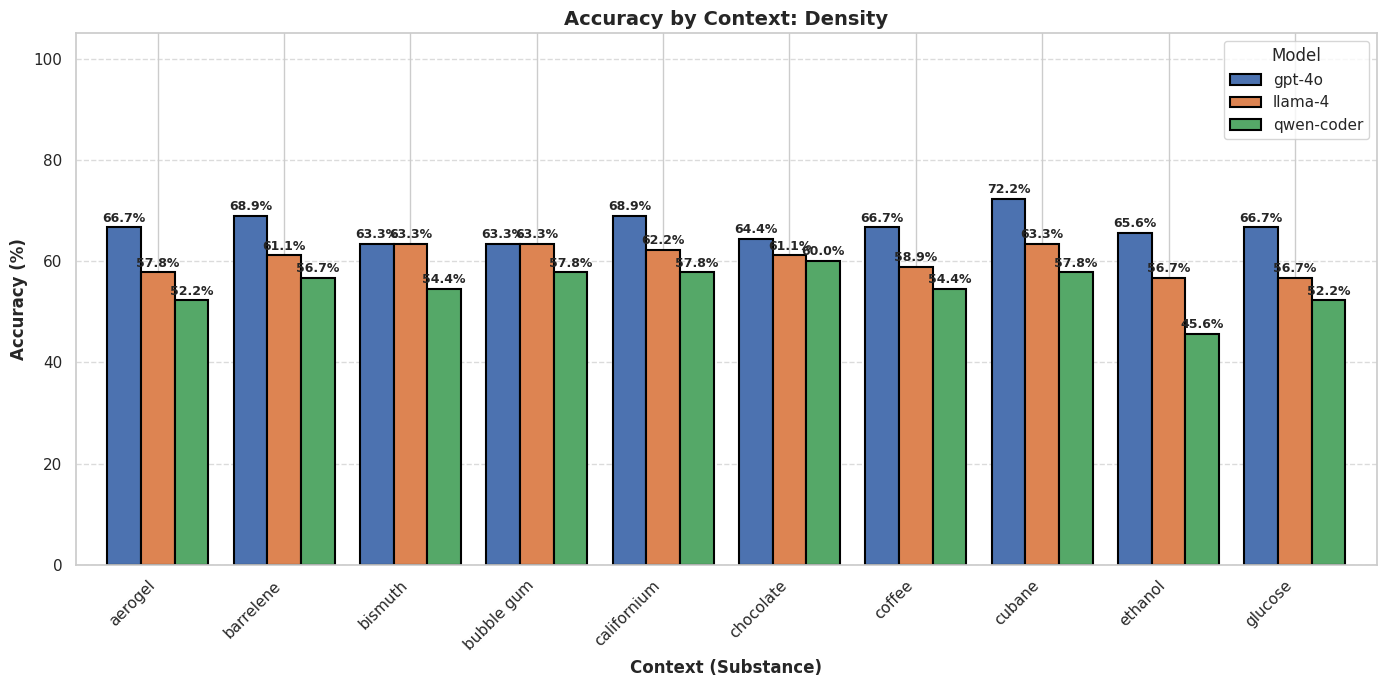


Accuracy by Context for density:
model        gpt-4o  llama-4  qwen-coder
context                                 
aerogel       66.67    57.78       52.22
barrelene     68.89    61.11       56.67
bismuth       63.33    63.33       54.44
bubble gum    63.33    63.33       57.78
californium   68.89    62.22       57.78
chocolate     64.44    61.11       60.00
coffee        66.67    58.89       54.44
cubane        72.22    63.33       57.78
ethanol       65.56    56.67       45.56
glucose       66.67    56.67       52.22


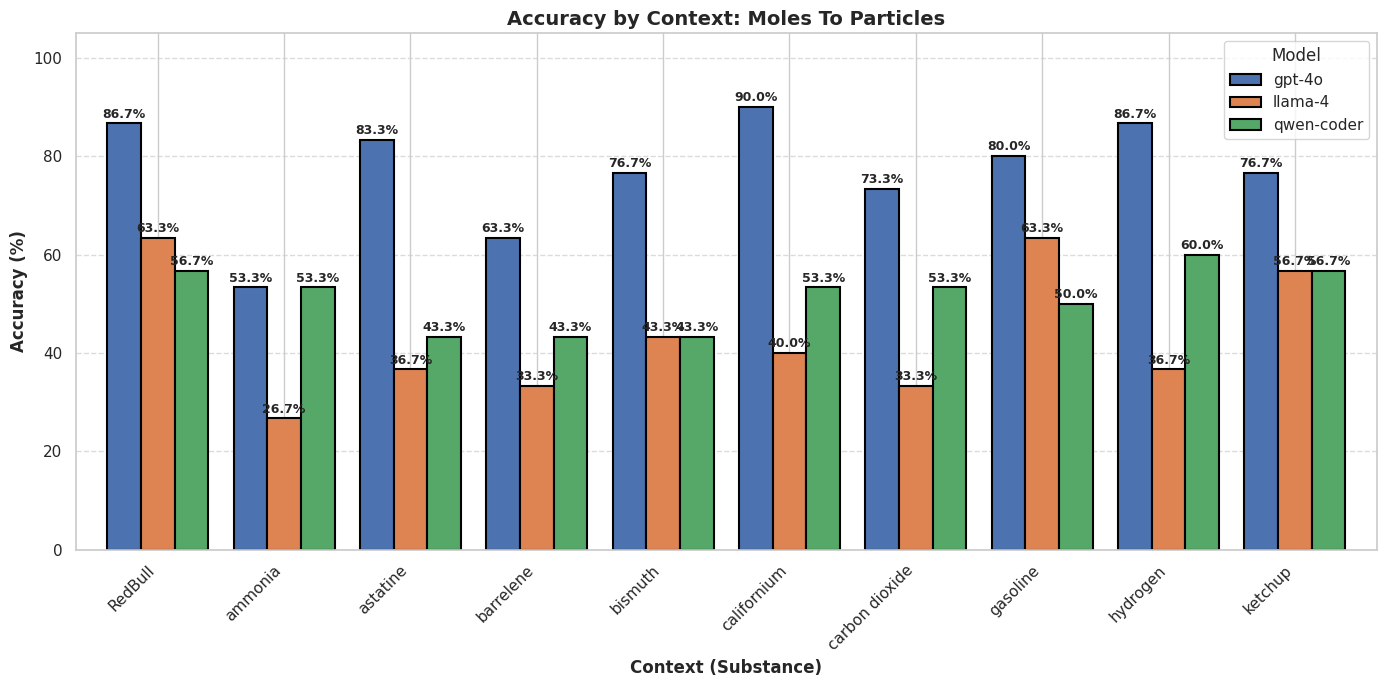


Accuracy by Context for moles_to_particles:
model           gpt-4o  llama-4  qwen-coder
context                                    
RedBull          86.67    63.33       56.67
ammonia          53.33    26.67       53.33
astatine         83.33    36.67       43.33
barrelene        63.33    33.33       43.33
bismuth          76.67    43.33       43.33
californium      90.00    40.00       53.33
carbon dioxide   73.33    33.33       53.33
gasoline         80.00    63.33       50.00
hydrogen         86.67    36.67       60.00
ketchup          76.67    56.67       56.67


In [ ]:
# Analyze specific contexts for density and moles
context_conversions = ['density', 'moles_to_particles']
df_context = df[df['conversion_name'].isin(context_conversions)].copy()

if len(df_context) > 0 and 'context' in df_context.columns:
    # Filter to only context versions (not context-free)
    df_context_only = df_context[df_context['context_type'] == 'context'].copy()
    
    if len(df_context_only) > 0:
        # Analyze by specific context
        context_accuracy = df_context_only.groupby(['conversion_name', 'context', 'model'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
        context_accuracy.columns = ['conversion_name', 'context', 'model', 'correct', 'total', 'accuracy']
        context_accuracy['accuracy'] = context_accuracy['accuracy'] * 100
        
        # Plot top contexts
        for conv_name in context_conversions:
            conv_context = context_accuracy[context_accuracy['conversion_name'] == conv_name]
            if len(conv_context) > 0:
                # Get top contexts by count
                top_contexts = conv_context.groupby('context')['total'].sum().nlargest(10).index
                conv_context_top = conv_context[conv_context['context'].isin(top_contexts)]
                
                if len(conv_context_top) > 0:
                    fig, ax = plt.subplots(figsize=(14, 7))
                    context_pivot = conv_context_top.pivot(index='context', columns='model', values='accuracy')
                    context_pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=1.5)
                    ax.set_title(f'Accuracy by Context: {conv_name.replace("_", " ").title()}', 
                               fontsize=14, fontweight='bold')
                    ax.set_xlabel('Context (Substance)', fontsize=12, fontweight='bold')
                    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
                    ax.legend(title='Model', fontsize=11)
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
                    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
                    ax.set_axisbelow(True)
                    ax.set_ylim(0, 105)
                    # Add percentage labels on top of bars
                    for container in ax.containers:
                        ax.bar_label(container, fmt='%.1f%%', fontsize=9, fontweight='bold', padding=2)
                    
                    plt.tight_layout()
                    plt.savefig(f'{output_dir}/context_specific_{conv_name}.png', dpi=300, bbox_inches='tight')
                    plt.show()
                    
                    print(f"\nAccuracy by Context for {conv_name}:")
                    print(context_pivot.round(2).to_string())
    else:
        print("No context-specific data available.")
else:
    print("No context field available in the dataset.")